# Conversion

In [1]:
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
model = load_model('quant_prune_model/KERAS_check_best_model.h5', custom_objects=co)

2024-07-05 00:55:29.945127: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-05 00:55:39.389528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import sys
import os

local_module_dir = os.path.join("/home/jovyan/work/hls4ml") # This should be changed the path of the local modified version of HLS4ML containing Vitis Accel backend
sys.path.insert(0, local_module_dir)

import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'

hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=config,
    output_dir='vitis_accel_prj',
    backend='VitisAccelerator',
    board='alveo-u55c',
    num_kernel=4,
    num_thread=8,
    hw_quant=True,
    batchsize=8192
)
hls_model.compile()

/home/jovyan/work/hls4ml/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 64]
Layer name: relu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: fc2, layer type: Dense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [Non

# Calculating Accuracy

In [3]:
import numpy as np
from hls4ml.backends.vitis_accelerator.vitis_accelerator_backend import VitisAcceleratorBackend

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
classes = np.load("classes.npy", allow_pickle=True)

y_qkeras = model.predict(X_test)

VitisAcceleratorBackend.numpy_to_dat(hls_model.config.backend, hls_model, X_test)
y_hls_hw = VitisAcceleratorBackend.dat_to_numpy(hls_model.config.backend, hls_model)

5188/5188 [==============================] - 12s 2ms/step


Accuracy pruned, quantized: 0.7650120481927711
Accuracy hls4ml: 0.7652168674698795


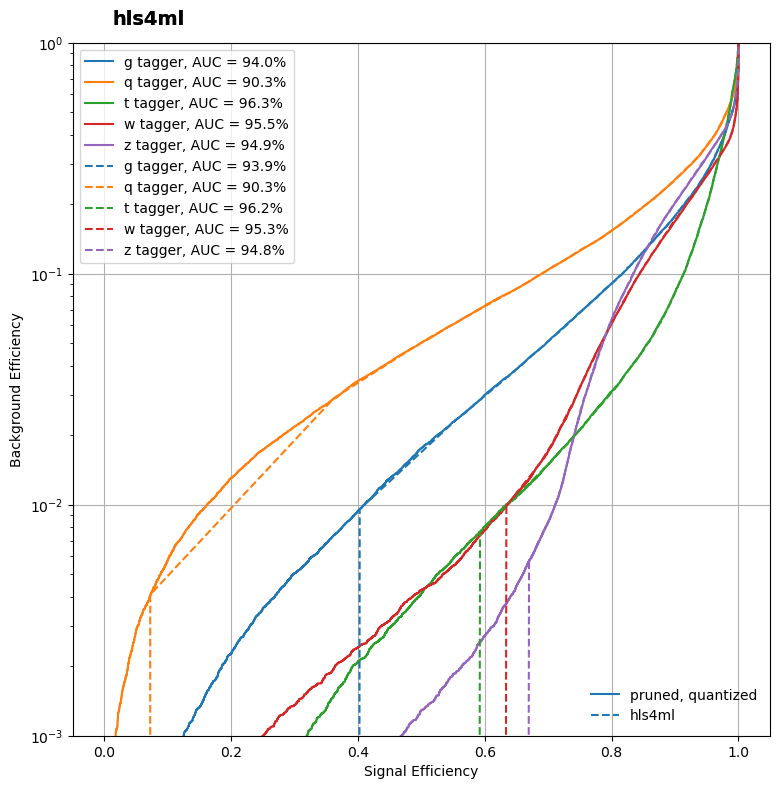

In [4]:
%matplotlib inline

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend import Legend

import plotting


print("Accuracy pruned, quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls_hw, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_qkeras, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls_hw, classes, linestyle='--')


lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]

leg = Legend(ax, lines, labels=['pruned, quantized', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)